# Analysis of segments and marketing personae associated

In [82]:
# importations
import pandas as pd
import numpy as np
import os
import io
import s3fs
import re
import pickle
import warnings
import matplotlib.pyplot as plt

In [83]:
def load_model(type_of_activity, model):
    BUCKET = f"projet-bdc2324-team1/Output_model/{type_of_activity}/{model}/"
    filename = model + '.pkl'
    file_path = BUCKET + filename
    with fs.open(file_path, mode="rb") as f:
        model_bytes = f.read()

    model = pickle.loads(model_bytes)
    return model


def load_test_file(type_of_activity):
    file_path_test = f"projet-bdc2324-team1/Generalization/{type_of_activity}/Test_set.csv"
    with fs.open(file_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
    return dataset_test

In [84]:
# exec(open('utils_segmentation.py').read())
warnings.filterwarnings('ignore')

# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# choose the type of companies for which you want to run the pipeline
type_of_activity = "sport"

In [85]:
# load test set
dataset_test = load_test_file(type_of_activity)

# Load Model 
model = load_model(type_of_activity, 'LogisticRegression_Benchmark')

In [86]:
dataset_test

customer_id  nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0        5_476624         4.0           1.0        100.00           1.0   
1        5_183496         1.0           1.0         55.00           1.0   
2        5_248456        17.0           1.0         80.00           1.0   
3        5_474758         4.0           1.0        120.00           1.0   
4        5_192421        34.0           2.0        416.00           1.0   
...           ...         ...           ...           ...           ...   
96091    9_761001         1.0           1.0         67.31           1.0   
96092    9_951910         1.0           1.0         61.41           1.0   
96093     9_54095         0.0           0.0          0.00           0.0   
96094    9_755241         1.0           1.0         79.43           1.0   
96095      9_2712         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  ...  country  gender_label  \
0                   0.000000                  0.0  ...       fr        female   
1                   0.000000                  0.0  ...       fr          male   
2                   0.000000                  0.0  ...       fr        female   
3                   0.000000                  0.0  ...       fr        female   
4                 363.061678                  0.0  ...       fr        female   
...                      ...                  ...  ...      ...           ...   
96091               0.000000                  1.0  ...       ch          male   
96092               0.000000                  1.0  ...       ch          male   
96093              -1.000000                  0.0  ...       ch        female   
96094               0.000000                  1.0  ...       fr          male   
96095              -1.000000                  0.0  ...      NaN          male   

       gender_female  gender_male  gender_other  country_fr  nb_campaigns  \
0                  1            0             0         1.0           0.0   
1                  0            1             0         1.0           0.0   
2                  1            0             0         1.0           0.0   
3                  1            0             0         1.0           0.0   
4                  1            0             0         1.0           0.0   
...              ...          ...           ...         ...           ...   
96091              0            1             0         0.0          15.0   
96092              0            1             0         0.0          12.0   
96093              1            0             0         0.0          29.0   
96094              0            1             0         1.0          20.0   
96095              0            1             0         NaN          31.0   

       nb_campaigns_opened               time_to_open  y_has_purchased  
0                      0.0                        NaN              0.0  
1                      0.0                        NaN              1.0  
2                      0.0                        NaN              0.0  
3                      0.0                        NaN              0.0  
4                      0.0           

In [180]:
# Processing
X_test = dataset_test[['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet',  'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened', 'country_fr']]

y_test = dataset_test[['y_has_purchased']]


X_test_segment = X_test

# X_test_segment.insert(X_test.shape[1], "country_fr", dataset_test["country_fr"])

# add y_has_purchased to X_test
X_test_segment["has_purchased"] = y_test

# Add prediction and probability to dataset_test
y_pred = model.predict(X_test)
X_test_segment["has_purchased_estim"] = y_pred

y_pred_prob = model.predict_proba(X_test)[:, 1]
X_test_segment['score'] = y_pred_prob

X_test_segment["segment"] = np.where(X_test_segment['score']<0.25, '1',
                   np.where(X_test_segment['score']<0.5, '2',
                   np.where(X_test_segment['score']<0.75, '3', '4')))

X_test_segment

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  is_email_true  ...  \
0                   0.000000                  0.0           True  ...   
1                   0.000000                  0.0           True  ...   
2                   0.000000                  0.0           True  ...   
3                   0.000000                  0.0           True  ...   
4                 363.061678                  0.0           True  ...   
...                      ...                  ...            ...  ...   
96091               0.000000                  1.0           True  ...   
96092               0.000000                  1.0           True  ...   
96093              -1.000000                  0.0           True  ...   
96094               0.000000                  1.0           True  ...   
96095              -1.000000                  0.0           True  ...   

       gender_female  gender_male  gender_other  nb_campaigns  \
0                  1            0             0           0.0   
1                  0            1             0           0.0   
2                  1            0             0           0.0   
3                  1            0             0           0.0   
4                  1            0             0           0.0   
...              ...          ...           ...           ...   
96091              0            1             0          15.0   
96092              0            1             0          12.0   
96093              1            0             0          29.0   
96094              0            1             0          20.0   
96095              0            1             0          31.0   

       nb_campaigns_opened  country_fr  has_purchased  has_purchased_estim  \
0                      0.0         1.0            0.0                  1.0   
1                      0.0         1.0            1.0                  0.0   
2                      0.0         1.0            0.0                  0.0   
3                      0.0         1.0            0.0                  1.0   
4                      0.0         1.0            1.0                  1.0   
...                    ...         ...            ...                  ...   
96091                  5.0         0.0            1.0                  1.0   
96092                  9.0         0.0            0.0                  1.0   
96093                  3.0         0.0            0.0                  0.0   
96094  

## 1. Business KPIs

In [181]:
# business figures
X_test_segment.groupby("segment")[["nb_tickets", "nb_purchases", "total_amount", "vente_internet_max", 
                                   "nb_tickets_internet"]].sum()

nb_tickets  nb_purchases  total_amount  vente_internet_max  \
segment                                                               
1            4324.0        1446.0  8.973214e+04               346.0   
2           36094.0       15451.0  1.138007e+06              8046.0   
3           65817.0       30677.0  2.209794e+06             14407.0   
4          392936.0      102142.0  1.650005e+07              6659.0   

         nb_tickets_internet  
segment                       
1                      870.0  
2                    19591.0  
3                    37260.0  
4                   112518.0

In [171]:
def df_business_fig(df, segment, list_var) :
    df_business_kpi = df.groupby(segment)[list_var].sum().reset_index()
    df_business_kpi.insert(1, "size", df.groupby(segment).size().values)
    all_var = ["size"] + list_var
    df_business_kpi[all_var] = 100 * df_business_kpi[all_var] / df_business_kpi[all_var].sum()

    return df_business_kpi

In [182]:
business_var = ["nb_tickets", "nb_purchases", "total_amount", "nb_campaigns"]
X_test_business_fig = df_business_fig(X_test_segment, "segment",
                                      business_var)
X_test_business_fig

segment       size  nb_tickets  nb_purchases  total_amount  nb_campaigns
0       1  48.776224    0.866236      0.965829      0.450065     41.498188
1       2  19.887404    7.230789     10.320206      5.707847     24.826893
2       3  21.990509   13.185261     20.490128     11.083558     17.737544
3       4   9.345862   78.717714     68.223837     82.758529     15.937376

In [57]:
def hist_segment_business_KPIs(df, segment, size, nb_tickets, nb_purchases, total_amount, nb_campaigns) :
    
    plt.figure()

    df_plot = df[[segment, size, nb_tickets, nb_purchases, total_amount, nb_campaigns]]
    
    x = ["number of\ncustomers", "number of\ntickets", "number of\npurchases", "total\namount", 
         "number of\ncampaigns"]

    # liste_var = [size, nb_tickets, nb_purchases, total_amount]
    
    bottom = np.zeros(5)
    
    # Définir une palette de couleurs
    colors = plt.cm.Blues(np.linspace(0.1, 0.9, 4))
    
    for i in range(4) :
        # print(str(df_plot[segment][i]))
        # segment = df_plot[segment][i]
        height = list(df_plot.loc[i,size:].values)
    
        plt.bar(x=x, height=height, label = str(df_plot[segment][i]), bottom=bottom, color=colors[i]#, width=0.1
               )
    
        bottom+=height

    # Ajuster les marges
    plt.subplots_adjust(left = 0.125, right = 0.8,
    bottom = 0.1, top = 0.9
                       )

    
    plt.legend(title = "segment", loc = "upper right", bbox_to_anchor=(1.2, 1))
    plt.ylabel("Fraction represented by the segment (%)")
    plt.title("Relative weight of each segment regarding business KPIs")
    # plt.show()
        

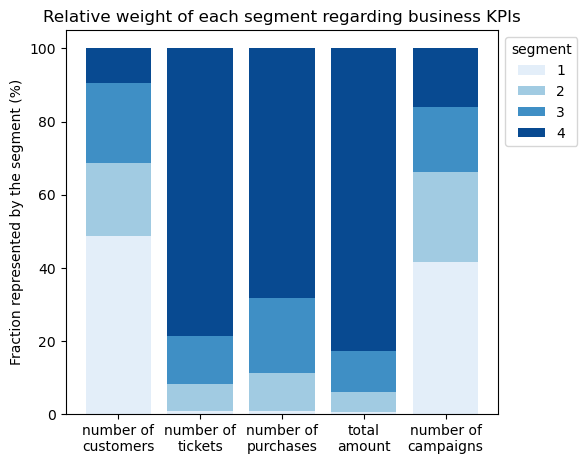

In [146]:
hist_segment_business_KPIs(X_test_business_fig, "segment", "size", *business_var)

In [13]:
activity =  "sport"
PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "segments_business_KPIs_" + activity
FILE_PATH_OUT_S3 = PATH + file_name + ".csv"

FILE_PATH_OUT_S3

'projet-bdc2324-team1/Output_marketing_personae_analysis/sport/segments_business_KPIs_sport.csv'

In [178]:
def save_file_s3_mp(File_name, type_of_activity):
    image_buffer = io.BytesIO()
    plt.savefig(image_buffer, format='png')
    image_buffer.seek(0)
    PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{type_of_activity}/"
    FILE_PATH_OUT_S3 = PATH + File_name + type_of_activity + '.png'
    with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
        s3_file.write(image_buffer.read())
    plt.close()

In [59]:
# save to Minio

activity =  "sport"
PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "segments_business_KPIs_" + activity
FILE_PATH_OUT_S3 = PATH + file_name + ".png"

hist_segment_business_KPIs(X_test_business_fig, "segment", "size", "nb_tickets", 
                           "nb_purchases", "total_amount", "nb_campaigns")

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png')
image_buffer.seek(0)

with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()



ClientError: An error occurred (InvalidAccessKeyId) when calling the PutObject operation: The Access Key Id you provided does not exist in our records.

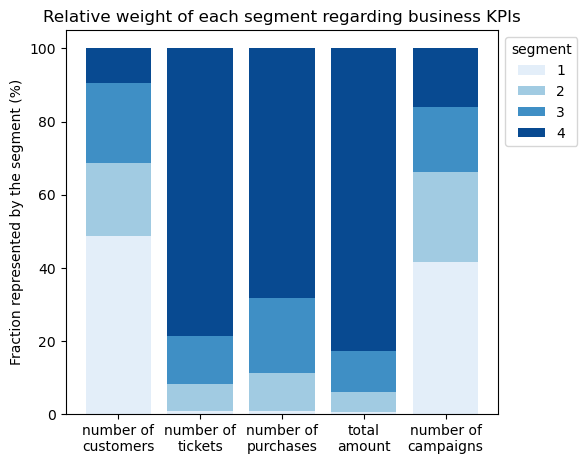

In [179]:
# with function

activity = "sport"

hist_segment_business_KPIs(X_test_business_fig, "segment", "size", "nb_tickets", 
                           "nb_purchases", "total_amount", "nb_campaigns")

save_file_s3_mp(File_name = "segments_business_KPIs_", type_of_activity = activity)

## 2. Spider plot summarizing sociodemographic characteristics and purchasing behaviour

In [165]:
def df_segment_mp(df, segment, gender_female, gender_male, gender_other, country_fr) :
    df_mp = df.groupby(segment)[[gender_female, gender_male, gender_other, country_fr]].mean().reset_index()
    df_mp.insert(3, "share_known_gender", X_test_segment_mp[gender_female]+X_test_segment_mp[gender_male])
    df_mp.insert(4, "share_of_women", X_test_segment_mp[gender_female]/(X_test_segment_mp["share_known_gender"]))
    return df_mp

In [159]:
# description of marketing personae

X_test_segment_mp = X_test_segment.groupby("segment")[['gender_female', 'gender_male', 'gender_other', 'country_fr']].mean().reset_index()
X_test_segment_mp.insert(3, "share_known_gender", X_test_segment_mp["gender_female"]+X_test_segment_mp["gender_male"])
X_test_segment_mp.insert(4, "share_of_women", X_test_segment_mp["gender_female"]/(X_test_segment_mp["share_known_gender"]))
X_test_segment_mp

segment  gender_female  gender_male  share_known_gender  share_of_women  \
0       1       0.222670     0.419974            0.642644        0.346491   
1       2       0.274449     0.556486            0.830935        0.330290   
2       3       0.272998     0.541312            0.814310        0.335251   
3       4       0.206547     0.622871            0.829418        0.249027   

   gender_other  country_fr  
0      0.357356    0.477963  
1      0.169065    0.763818  
2      0.185690    0.661414  
3      0.170582    0.657373

In [183]:
X_test_segment_mp = df_segment_mp(X_test_segment, "segment", "gender_female", 
                                  "gender_male", "gender_other", "country_fr")
X_test_segment_mp

segment  gender_female  gender_male  share_known_gender  share_of_women  \
0       1       0.222670     0.419974            0.642644        0.346491   
1       2       0.274449     0.556486            0.830935        0.330290   
2       3       0.272998     0.541312            0.814310        0.335251   
3       4       0.206547     0.622871            0.829418        0.249027   

   gender_other  country_fr  
0      0.357356    0.477963  
1      0.169065    0.763818  
2      0.185690    0.661414  
3      0.170582    0.657373

In [150]:
# purchasing behaviour

X_test_segment["share_tickets_internet"] = X_test_segment["nb_tickets_internet"]/X_test_segment["nb_tickets"]
X_test_segment["share_campaigns_opened"] = X_test_segment["nb_campaigns_opened"]/X_test_segment["nb_campaigns"]
X_test_segment_pb = X_test_segment.groupby("segment")[["share_tickets_internet", "share_campaigns_opened", "opt_in"]].mean().reset_index()
X_test_segment_pb

segment  share_tickets_internet  share_campaigns_opened    opt_in
0       1                0.247851                0.136462  0.595110
1       2                0.630889                0.233739  0.411281
2       3                0.679076                0.297721  0.045523
3       4                0.588024                0.366443  0.134395

In [168]:
def df_segment_pb (df, segment, nb_tickets_internet, nb_tickets, nb_campaigns_opened, nb_campaigns, opt_in) :
    df_used = df
    df_used["share_tickets_internet"] = df_used[nb_tickets_internet]/df_used[nb_tickets]
    df_used["share_campaigns_opened"] = df_used[nb_campaigns_opened]/df_used[nb_campaigns]
    df_pb = df_used.groupby(segment)[["share_tickets_internet", "share_campaigns_opened", opt_in]].mean().reset_index()
    return df_pb

In [170]:
X_test_segment_pb = df_segment_pb(X_test_segment, "segment", "nb_tickets_internet", "nb_tickets", 
                                  "nb_campaigns_opened", "nb_campaigns", "opt_in")
X_test_segment_pb

segment  share_tickets_internet  share_campaigns_opened    opt_in
0       1                0.247851                0.136462  0.595110
1       2                0.630889                0.233739  0.411281
2       3                0.679076                0.297721  0.045523
3       4                0.588024                0.366443  0.134395

In [151]:
X_test_segment_caract = pd.concat([X_test_segment_pb, X_test_segment_mp[['share_known_gender', 'share_of_women', 'country_fr']]], axis=1)
X_test_segment_caract

segment  share_tickets_internet  share_campaigns_opened    opt_in  \
0       1                0.247851                0.136462  0.595110   
1       2                0.630889                0.233739  0.411281   
2       3                0.679076                0.297721  0.045523   
3       4                0.588024                0.366443  0.134395   

   share_known_gender  share_of_women  country_fr  
0            0.642644        0.346491    0.477963  
1            0.830935        0.330290    0.763818  
2            0.814310        0.335251    0.661414  
3            0.829418        0.249027    0.657373

In [152]:
X_test_segment_caract.loc[:,"share_tickets_internet":].max()

share_tickets_internet    0.679076
share_campaigns_opened    0.366443
opt_in                    0.595110
share_known_gender        0.830935
share_of_women            0.346491
country_fr                0.763818
dtype: float64

In [153]:
# def d'une fonction associée - KEEP THIS !!!

def radar_mp_plot(df, categories, index) :
    categories = categories

    # true values are used to print the true value in parenthesis
    tvalues = list(df.loc[index,categories]) 

    max_values = df[categories].max()

    # values are true values / max among the 4 segments, allows to 
    # put values in relation with the values for other segments
    # if the point has a maximal abscisse it means that value is maximal for the segment considered
    # , event if not equal to 1
    
    values = list(df.loc[index,categories]/max_values)
                  
    # values normalized are used to adjust the value around the circle
    # for instance if the maximum of values is equal to 0.8, we want the point to be 
    # at 8/10th of the circle radius, not at the edge 
    values_normalized = [ max(values) * elt for elt in values]

    # Nb of categories
    num_categories = len(categories)
    
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
    # Initialize graphic
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # we have to draw first a transparent line (alpha=0) of values to adjust the radius of the circle
    # which is based on max(value)
    ax.plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
    ax.plot(angles + angles[:1], values_normalized + values_normalized[:1], color='black', alpha = 0.5, linewidth=1.2)
    
    # fill the sector
    ax.fill(angles, values_normalized, color='orange', alpha=0.4)
    
    # labels
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ticks = [categories[i].replace("_"," ") + f"\n({round(100 * tvalues[i],2)}%)" for i in range(len(categories))]
    ax.set_xticklabels(ticks, color="black")
    
    ax.spines['polar'].set_visible(False)
    
    plt.title(f'Characteristics of the segment {index+1}\n')
    
    # plt.show()

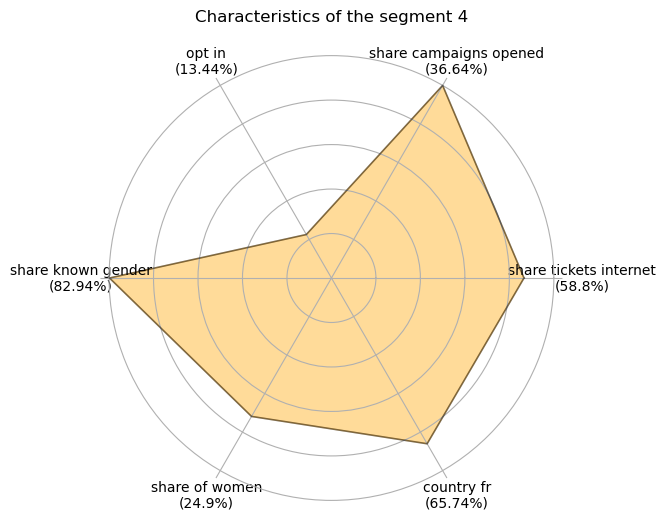

In [157]:
categories = list(X_test_segment_caract.drop("segment", axis=1).columns)
#for i in range(4) :
#    radar_mp_plot(df=X_test_segment_caract, categories=categories, index=i)
radar_mp_plot(df=X_test_segment_caract, categories=categories, index=3)

In [739]:
# export to MinIo

activity =  "sport"
PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "spider_chart_" + activity + "_sgt_" + str(index)
FILE_PATH_OUT_S3 = PATH + file_name + ".csv"


radar_mp_plot(df=X_test_segment_caract, categories=categories, index=3)

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png')
image_buffer.seek(0)

with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()

SyntaxError: invalid syntax (4005960846.py, line 6)

In [740]:
activity =  "sport"
PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "spider_chart_" + activity + "_sgt_" + str(index)
FILE_PATH_OUT_S3 = PATH + file_name + ".csv"
FILE_PATH_OUT_S3

'projet-bdc2324-team1/Output_marketing_personae_analysis/sport/spider_chart_sport_sgt_3.csv'

In [154]:
# general function to have the 4 radars in one plot

def radar_mp_plot_all(df, categories) :
    
    nb_segments = df.shape[0]
    categories = categories

    # Initialize graphic
    fig, ax = plt.subplots(2,2, figsize=(25, 20), subplot_kw=dict(polar=True))
    
    for index in range(nb_segments) :
        row = index // 2  # Division entière pour obtenir le numéro de ligne
        col = index % 2 
            
        df = X_test_segment_caract
    
        # true values are used to print the true value in parenthesis
        tvalues = list(df.loc[index,categories]) 
        
        max_values = df[categories].max()
        
        # values are true values / max among the 4 segments, allows to 
        # put values in relation with the values for other segments
        # if the point has a maximal abscisse it means that value is maximal for the segment considered
        # , event if not equal to 1
        
        values = list(df.loc[index,categories]/max_values)
                      
        # values normalized are used to adjust the value around the circle
        # for instance if the maximum of values is equal to 0.8, we want the point to be 
        # at 8/10th of the circle radius, not at the edge 
        values_normalized = [ max(values) * elt for elt in values]
        
        # Nb of categories
        num_categories = len(categories)

        angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
        # we have to draw first a transparent line (alpha=0) of values to adjust the radius of the circle
        # which is based on max(value)
        ax[row, col].plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
        ax[row, col].plot(angles + angles[:1], values_normalized + values_normalized[:1], color='black', alpha = 0.5, linewidth=1.2)
        
        # fill the sector
        ax[row, col].fill(angles, values_normalized, color='orange', alpha=0.4, label = index)
        
        # labels
        ax[row, col].set_yticklabels([])
        ax[row, col].set_xticks(angles)
        ticks = [categories[i].replace("_"," ") + f"\n({round(100 * tvalues[i],2)}%)" for i in range(len(categories))]
        ax[row, col].set_xticklabels(ticks, color="black", size = 20)
        
        ax[row, col].spines['polar'].set_visible(False)
        
        # plt.title(f'Characteristics of the segment {index+1}\n')
        ax[row, col].set_title(f'Characteristics of the segment {index+1}\n', size = 24)

    # plt.show()

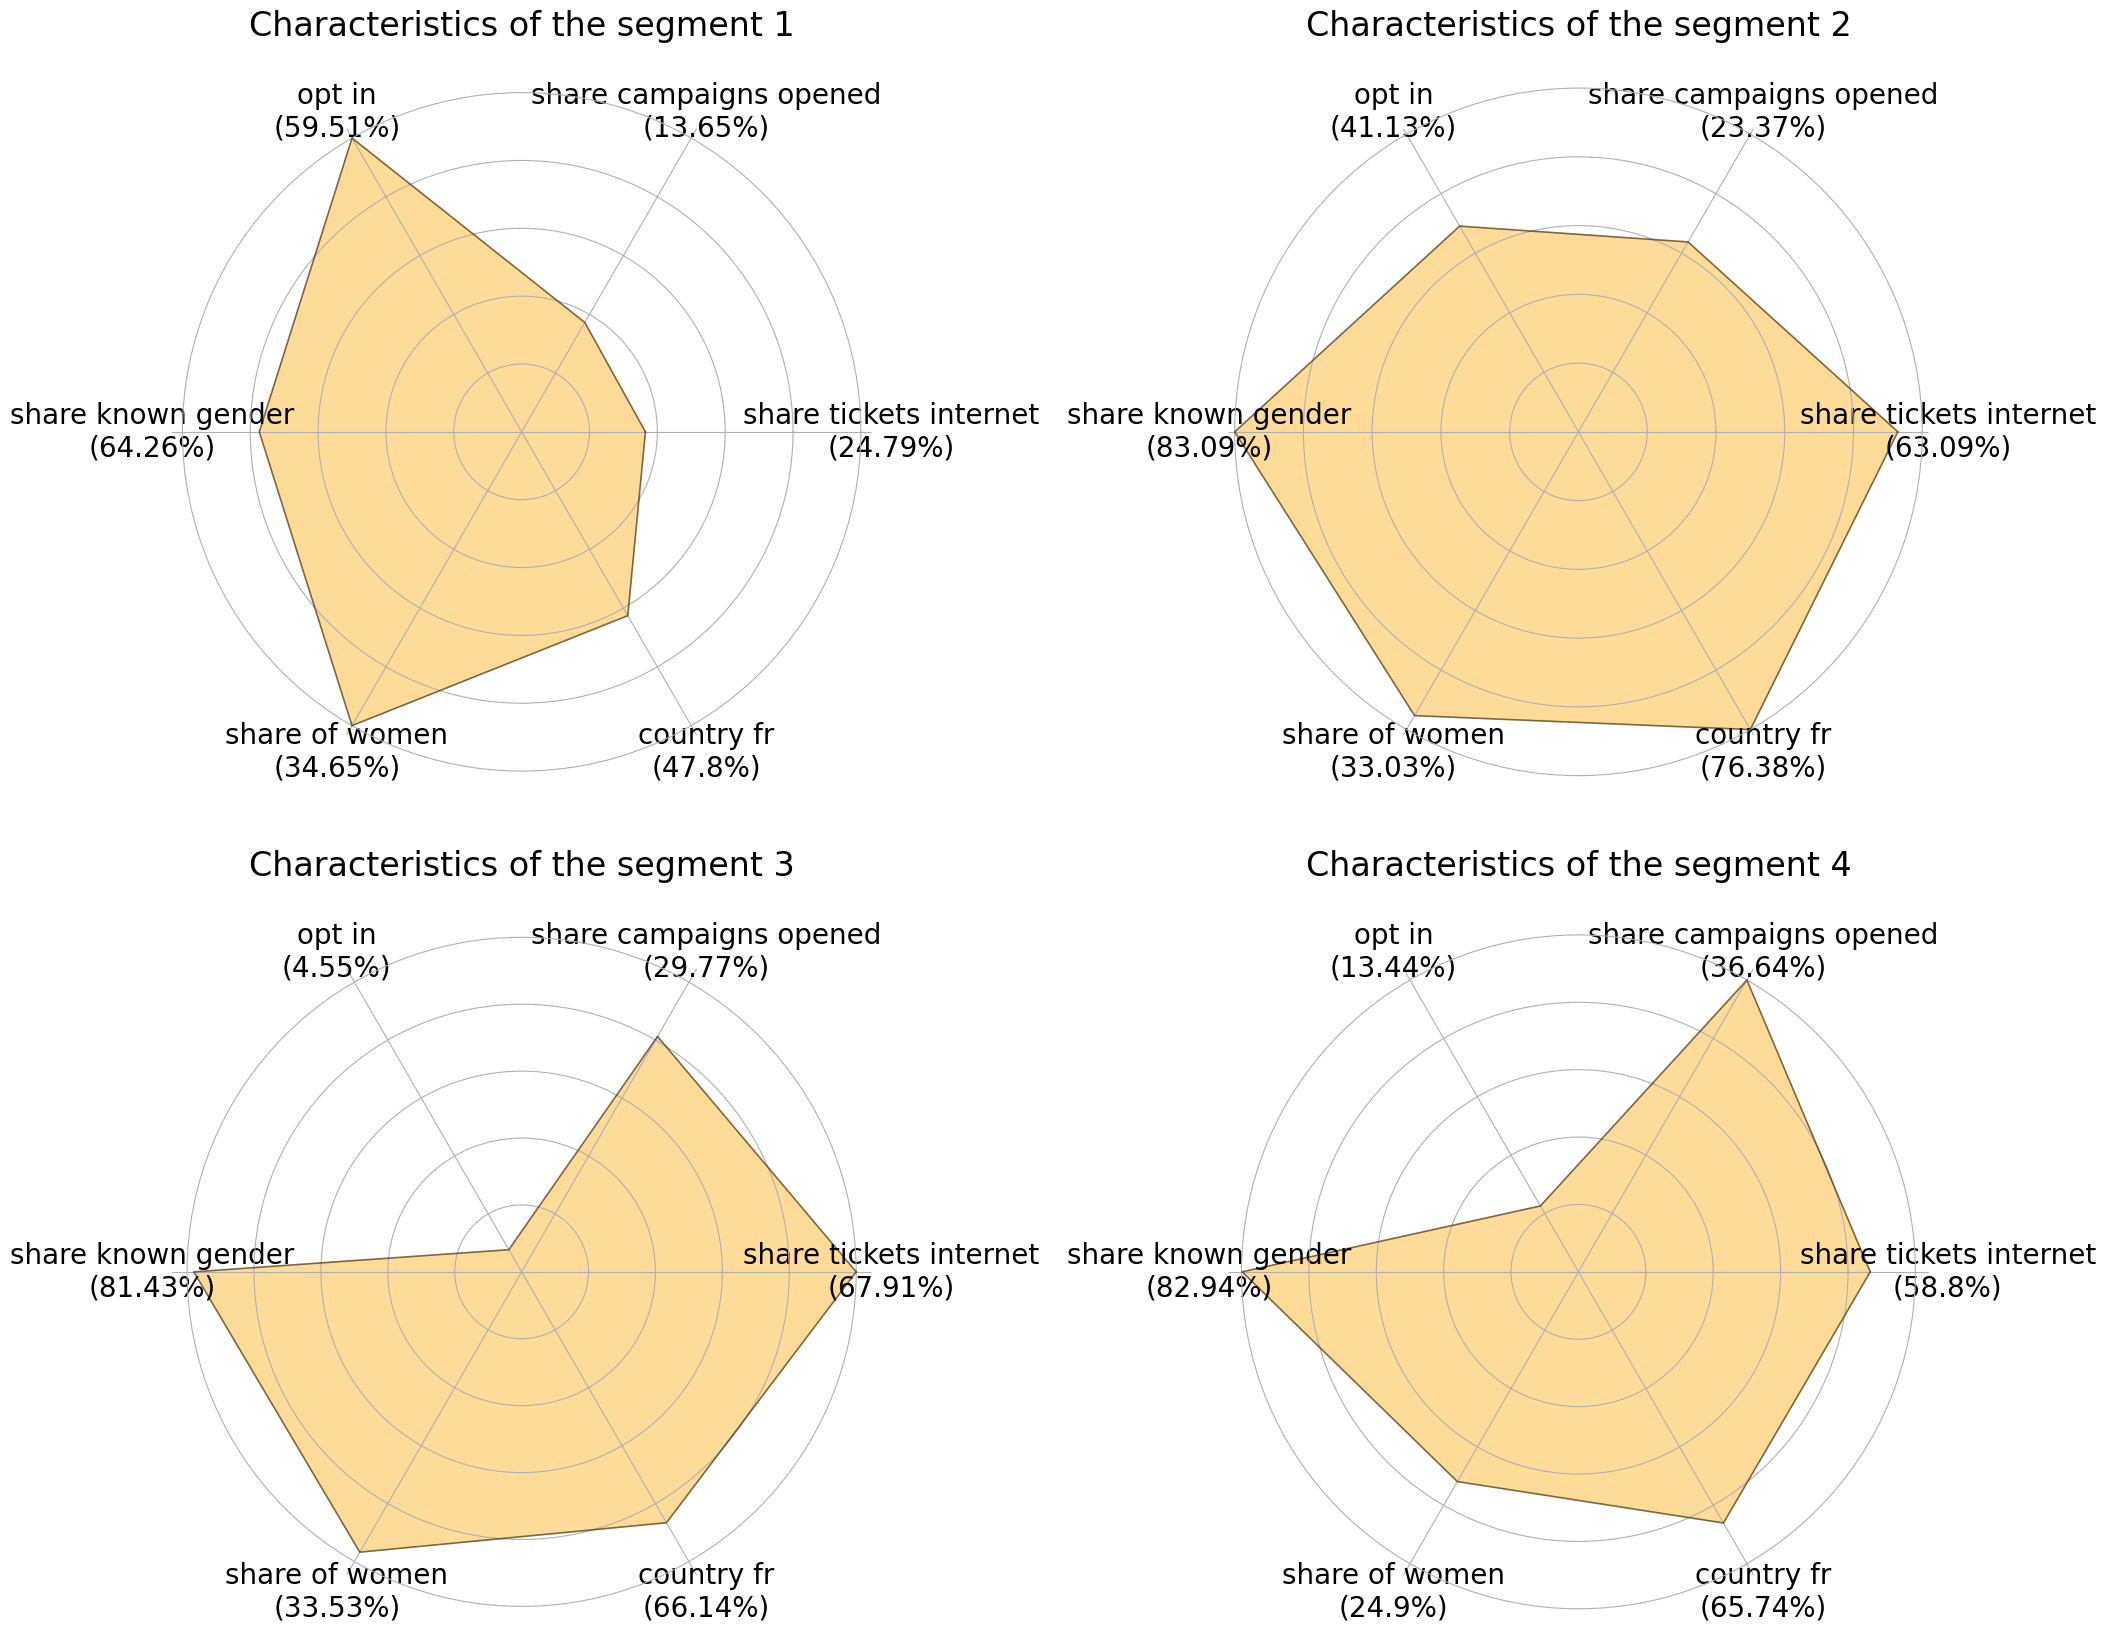

In [156]:
categories = list(X_test_segment_caract.drop("segment", axis=1).columns)
radar_mp_plot_all(df=X_test_segment_caract, categories=categories)

In [81]:
# export to MinIo

# activity =  "sport"
# PATH = f"projet-bdc2324-team1/Output_marketing_personae_analysis/{activity}/"

file_name = "spider_chart_all_" + activity
FILE_PATH_OUT_S3 = PATH + file_name + ".png"

radar_mp_plot_all(df=X_test_segment_caract, categories=categories)

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png')
image_buffer.seek(0)

with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()

## --- end of the main part --- here are just some attempts --- ##

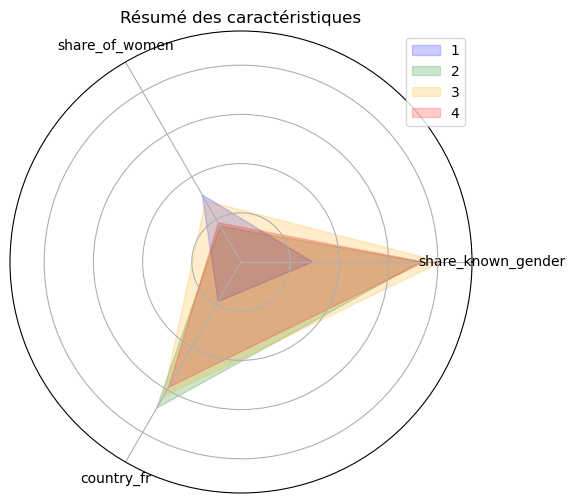

In [489]:
colors = plt.cm.Blues(np.linspace(0.1, 0.9, 4)) 
colors = ["blue", "green", "orange", "red"]

# Initialisez le graphique en étoile
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i in range(4) :

    # Caractéristiques et valeurs associées (exemple)
    categories = ['share_known_gender', 'share_of_women', 'country_fr']
    values = list(X_test_segment_mp.loc[i,categories])  # Exemple de valeurs, ajustez selon vos données
    
    values_normalized = [ max(values) * elt for elt in values]
    
    # Nombre de caractéristiques
    num_categories = len(categories)
    
    # Créer un angle pour chaque axe
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
    
    # Tracer uniquement le contour du polygone
    ax.plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
    # ax.plot(angles + angles[:1], values_normalized + values_normalized[:1], color='blue', alpha = 0.3, linewidth=1.5)
    
    # Remplir le secteur central avec une couleur
    ax.fill(angles, values_normalized, color=colors[i], alpha=0.2, label = str(i+1))

# Étiqueter les axes
ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(categories)
ax.legend()

# Titre du graphique
plt.title('Résumé des caractéristiques')

# Afficher le graphique
plt.show()

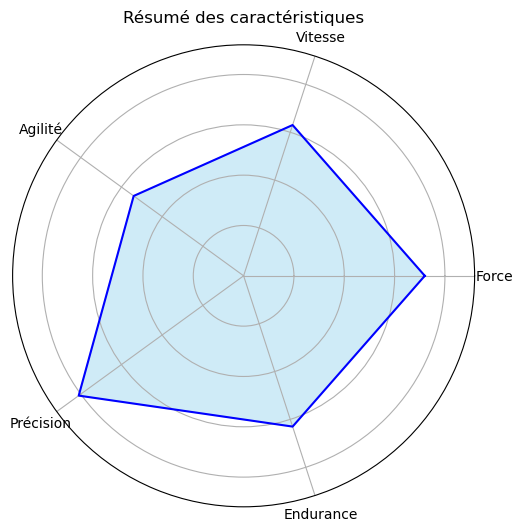

In [301]:
# KEEP THIS CODE !!

# Caractéristiques et valeurs associées (exemple)
categories = ['Force', 'Vitesse', 'Agilité', 'Précision', 'Endurance']
values = [8, 7, 6, 9, 7]  # Exemple de valeurs, ajustez selon vos données

# Plage de valeurs maximales pour chaque caractéristique
max_range = [20, 20, 20, 20, 20]

values_normalized = [2 * max(values) * x / y for x, y in zip(values, max_range)]

# Nombre de caractéristiques
num_categories = len(categories)

# Créer un angle pour chaque axe
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Initialisez le graphique en étoile
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Tracer uniquement le contour du polygone
ax.plot(angles + angles[:1], values + values[:1], color='skyblue', alpha=0, linewidth=1.5)
ax.plot(angles + angles[:1], values_normalized + values_normalized[:1], color='blue', linewidth=1.5)

# Remplir le secteur central avec une couleur
ax.fill(angles, values_normalized, color='skyblue', alpha=0.4)

# Étiqueter les axes
ax.set_yticklabels([])
ax.set_xticks(angles)
ax.set_xticklabels(categories)

# Titre du graphique
plt.title('Résumé des caractéristiques')

# Afficher le graphique
plt.show()


In [149]:
def radar_chart(values, categories, segment) :
    # Caractéristiques et valeurs associées (exemple)
    categories = categories
    values = values  # Exemple de valeurs, ajustez selon vos données
    
    # Nombre de caractéristiques
    num_categories = len(categories)
    
    # Créer un angle pour chaque axe
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
    # Répéter le premier angle pour fermer la figure
    values += values[:1]
    angles += angles[:1]
    
    # Initialisez le graphique en étoile
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Tracer les lignes radiales
    ax.fill(angles, values, color='skyblue', alpha=0.4)
    
    # Tracer les points sur les axes radiaux
    ax.plot(angles, values, color='blue', linewidth=2, linestyle='solid')

    # Afficher les valeurs associées sous les noms de variables
    """
    for i, angle in enumerate(angles[:-1]):
        x = angle
        y = values[i] + 0.2  # Ajustez la distance des valeurs par rapport au centre
        plt.text(x, y, str(values[i]), color='black', ha='center', fontsize=10)
        """
    
    # Remplir le secteur central avec une couleur
    # ax.fill(angles, values, color='skyblue', alpha=0.4)

    
    # Étiqueter les axes
    ax.set_yticklabels([])
    #ax.set_xticks(angles[:-1])
    #ax.set_xticklabels(categories, # fontsize=12, ha='right', rotation=45
    #                  )
    # ax.set_xticklabels(categories, fontsize=10, color='black', ha='right')

    labels = [f"{category} = {round(100 *value,2)}%" for category, value in zip(categories, values[:-1])]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, color='black', ha='right')
    
    # Titre du graphique
    plt.title(f'Caracteristics of segment {segment}')
    
    # Afficher le graphique
    plt.show()


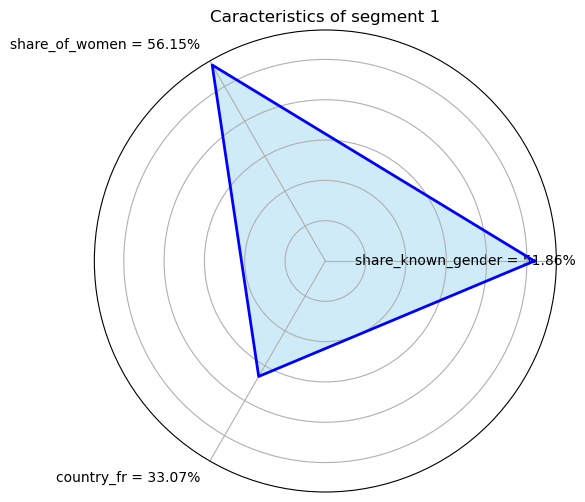

In [150]:
categories= ["share_known_gender","share_of_women","country_fr"]
radar_chart(values=X_test_segment_mp.loc[0,categories].values.tolist(), categories= categories,
            segment = "1")